Hunter Bennett | Glass Lab | Kupffer Strains Project | April 27 2021  

This series of notebooks is for manuscript preparation of "final" figures for import into Adobe Illustrator.

This notebook in particular prepares the ATAC and H3K27Ac scatter plots as one large figure.

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [2]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500

# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [3]:
dataDirectory = '/home/h1bennet/strains/results/11_Strains_Leptin_6h_ATAC/'
workingDirectory = '/home/h1bennet/strains/results/10_Strains_Manuscript_Prep/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Make folder for these figures

In [4]:
if not os.path.isdir('./leptin_atac_figure/'):
    os.mkdir('./leptin_atac_figure/')

# Import ATAC data

In [5]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    dataDirectory+'./peakQuan/aj_diff_output.txt',
    dataDirectory+'./peakQuan/allRawTags.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (89968, 38)
getDiffExpression selected transcripts (84876, 28)
annotatePeaks selected peaks (84876, 38)


dict_keys(['00_aj_control vs. 01_aj_leptin6h'])

In [6]:
comps = ['00_aj_control vs. 01_aj_leptin6h']
labels = ['AJ Control\nLog2(Norm. Tags)',
          'AJ Leptin 6h\nLog2(Norm. Tags)']

groups = [[[13,14,15,16],
         [17,18,19]]]

cols = []
for i in groups:
    for j in i:
        cols.extend(j)
cols = [cols]

colors = [['#a50f15', '#a50f15']]
log2fc = np.log2(2)
pval = 0.05

00_aj_control vs. 01_aj_leptin6h
N peaks downregulated 3927
N peaks upregulated 2018



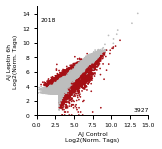

In [7]:
for key, col, group, color in zip(comps, cols, groups, colors):
    
    # make columns for plotting
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    de = de.reindex(de.index[(de.g0_mean >= 3) | (de.g1_mean >= 3)])
    
    dot_colors = []
    dot_sizes = []
    
    # create dot size list
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -log2fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > log2fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('#bdbdbd')
            dot_sizes.append(0.5)
    
    # print DE peaks
    print(key)
    print('N peaks downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -log2fc)))
    print('N peaks upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > log2fc)))
    print('')
    
    fig, ax = plt.subplots(figsize=(2,2))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=0.5, #de.log10p+0.05,
        c=dot_colors,
        rasterized=True)
    
    
    # set labels
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
    ax.text(0.5,13,
        s='%i' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1))),
        fontsize=6,
        c='k')
    ax.text(13,0.5,
        s='%i' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1))),
        fontsize=6,
        c='k',
        rotation=0)
    
    plt.savefig('./leptin_atac_figure/aj_leptin_6h_atac_scatter_notext.pdf', bbox_inches='tight')
    # plt.close()

# Motif enrichment...

In [8]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob(dataDirectory+'/motif_calling/*/knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[-2]
    
    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame.to_csv(dataDirectory+'/homer_known_motifs_differential_log.txt', sep='\t')

Filter for aj only.

In [9]:
df = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('aj')]
df = df.loc[:, df.columns.str.contains('distal')]
df = df.loc[:, ~df.columns.str.contains('nobg_nodenovo')]

In [10]:
motifs = []
top_n = 5
for col in df.columns:
    motifs.extend(df.sort_values(col, ascending=True).index.tolist()[:top_n])
    

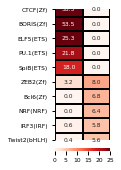

In [11]:
fig, ax = plt.subplots(figsize=(1,3))

tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]

sns.heatmap(tmp_df,
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            vmax=25,
            annot=True,
            fmt='.1f',
            xticklabels=0,
            cbar_kws={'orientation':'horizontal',
                      'pad':0.05})

plt.savefig('./leptin_atac_figure/aj_leptin_6h_atac_top5_motifs.pdf', bbox_inches='tight')


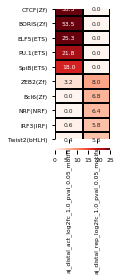

In [12]:
fig, ax = plt.subplots(figsize=(1,3))

tmp_df = -df.loc[motifs]
tmp_df.index = tmp_df.index.str.split('/').str[0]

sns.heatmap(tmp_df,
            cmap='Reds',
            linewidth=1,
            linecolor='k',
            vmax=25,
            annot=True,
            fmt='.1f',
            xticklabels=1,
            cbar_kws={'orientation':'horizontal',
                      'pad':0.05})
